---
format: 
  html:
    toc: false
    page-layout: full
execute:
    echo: false
---

# Building our random forest model

Now that we have loaded and processed our data, we will proceed to build and test our random forest model.


In [15]:
%pip install statsmodels

# load necessary libraries
import os
import requests
import pysal
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import folium
import osmnx as ox
import statsmodels.api as sm
from census import Census
from us import states
from folium import plugins
from sklearn.preprocessing import QuantileTransformer
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_poisson_deviance

Note: you may need to restart the kernel to use updated packages.


In [2]:
# load processed data
geo_data = gpd.read_file("geo_data_crashes.geojson")

## Model design

Because the goal of this project is to predict future non-motorist crashes, we need to show how well our model can perform on existing data where we can verify predictions with observed data. Therefore, we will predict 2023 crashes using data from the prior five years - 2018 through 2022.

### Preparing the predictors

Along with our crash count columms, we select variables associated with commuting patterns, vehicle ownership, and road characteristics.

#### Commuting patterns

#### Vehicle ownership

#### Road characteristics


In [3]:
# select necessary columns
predictor_columns = [col for col in geo_data.columns if col.startswith("crash_") or col.endswith("_proportion") or col == "total_length" or col == "intersection_count" or col.startswith("pct_")]

# ensure the 2023 crash variable is included
target_column = "crash_2023"

# filter the data to include only the selected columns and the target variable
data = geo_data[predictor_columns + [target_column]]

# drop rows with missing values
data = data.dropna()

# set columns for training and use data from 2018 through 2022
train_columns = [col for col in predictor_columns if col.startswith("crash_2018") or col.startswith("crash_2019") or col.startswith("crash_2020") or col.startswith("crash_2021") or col.startswith("crash_2022") or col.endswith("_proportion") or col == "total_length" or col == "intersection_count" or col.startswith("pct_")]

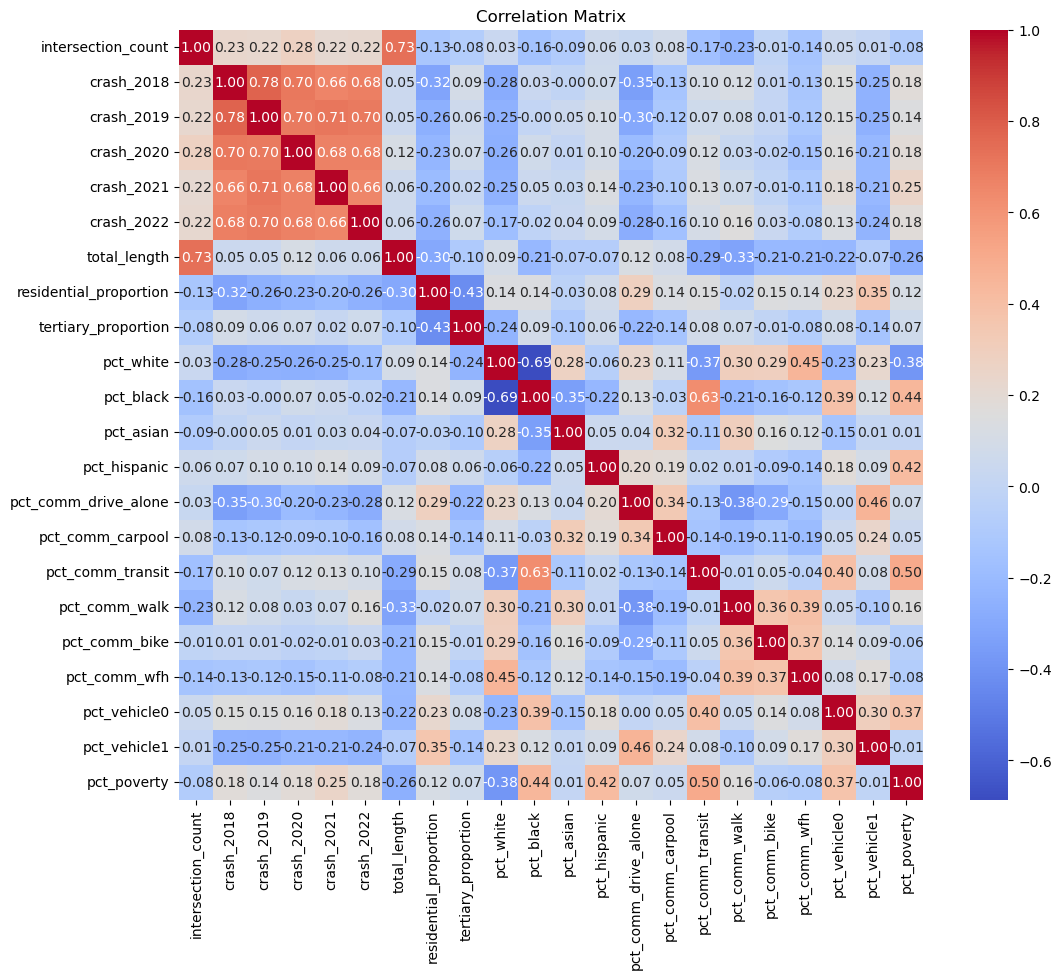

In [4]:
# filter data to include only selected columns
corr_data = geo_data[train_columns]

# compute correlation matrix
correlation_matrix = corr_data.corr()

# visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [10]:
# set up training and testing datasets
X_train = data[train_columns]
y_train = data[target_column]
X_test = data[train_columns]
y_test = data[target_column]

# deduplicate y columns
y_train = y_train.loc[:, ~y_train.columns.duplicated()]
y_test = y_test.loc[:, ~y_test.columns.duplicated()]

# set up random forest pipeline
forest = make_pipeline(
    RobustScaler(), RandomForestRegressor(n_estimators=100, random_state=42)
)

# generate hyperparameter grid
model_step = "randomforestregressor"
param_grid = {
    f"{model_step}__n_estimators": [5, 10, 15, 20, 30, 50, 100, 200],
    f"{model_step}__max_depth": [2, 5, 7, 9, 13, 21, 33, 51],
}

# create grid and use 3-fold CV
grid = GridSearchCV(forest, param_grid, cv=3, verbose=1)

# run the model
grid.fit(X_train, y_train)

# display optimized hyperparameters
grid.best_params_

# show score
grid.score(X_test, y_test)

# show feature importance
#feature_importances = pd.Series(model.feature_importances_, index=train_columns).sort_values(ascending=False)
#print("Feature Importances:")
#print(feature_importances)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


/Users/songj/miniforge3/envs/musa-550-fall-2024/lib/python3.10/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/songj/miniforge3/envs/musa-550-fall-2024/lib/python3.10/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/songj/miniforge3/envs/musa-550-fall-2024/lib/python3.10/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/songj/miniforge3/envs/musa-550-fall-2024/lib/python3.10/site-packages/sklearn/base.py:1

0.8058470025648714

In [11]:
# evaluate the best random forest model
best_random = grid.best_estimator_

# make the predictions
predictions = best_random.predict(X_test)

# convert observed values to array
y_test_array = y_test.values.flatten()

# calculate absolute error
errors = abs(predictions - y_test_array)
avg_error = np.mean(errors)

# calculate poisson deviance
poisson_deviance = mean_poisson_deviance(y_test_array, predictions)

print("Model Performance")
print(f"Average Absolute Error: {avg_error:0.4f}")
print("We do not report MAPE because of zero values in the observed data")
print(f"Poisson Deviance: {poisson_deviance}")

Model Performance
Average Absolute Error: 1.0845
We do not report MAPE because of zero values in the observed data
Poisson Deviance: 0.7883261959678517


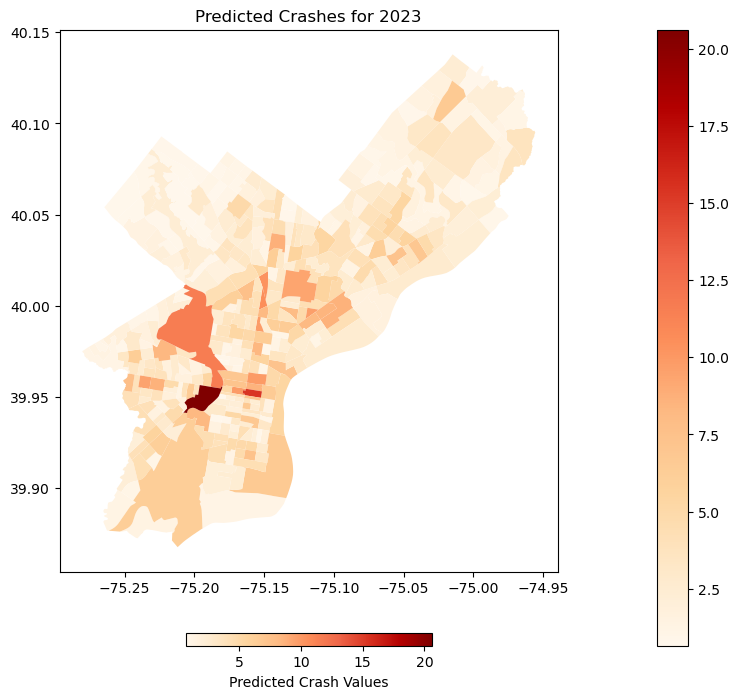

In [18]:
# Merge predictions back into geo_data
geo_data['predicted_crashes'] = predictions

# Define a color map and normalization
vmin = geo_data['predicted_crashes'].min()
vmax = geo_data['predicted_crashes'].max()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = 'OrRd'  # Using 'OrRd' as the color map

# Create the figure and axis
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot the map for predicted crashes
geo_data.plot(column='predicted_crashes', cmap=cmap, norm=norm, ax=ax, legend=True)
ax.set_title('Predicted Crashes for 2023')

# Add a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1)
cbar.set_label('Predicted Crash Values')

plt.show()

In [12]:
# add a constant to the predictors (intercept term)
X_train_nb = sm.add_constant(X_train)
X_test_nb = sm.add_constant(X_test)

# fit the poisson regression model
nb_model = sm.GLM(y_train, X_train_nb, family=sm.families.NegativeBinomial()).fit()

# make predictions
nb_predictions = nb_model.predict(X_test_nb)

# calculate the absolute errors
nb_errors = abs(nb_predictions - y_test_array)

# calculate average error
nb_avg_error = np.mean(nb_errors)

# calculate poisson deviance
nb_poisson_deviance = mean_poisson_deviance(y_test_array, nb_predictions)


print("Negative binomial regression model performance")
print(f"Average absolute error: {nb_avg_error:0.4f}")
print("We do not report MAPE because of zero values in the observed data")
print(f"Poisson Deviance: {nb_poisson_deviance}")

Negative binomial regression model performance
Average absolute error: 1.9346
We do not report MAPE because of zero values in the observed data
Poisson Deviance: 1.7379535290544768


/Users/songj/miniforge3/envs/musa-550-fall-2024/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


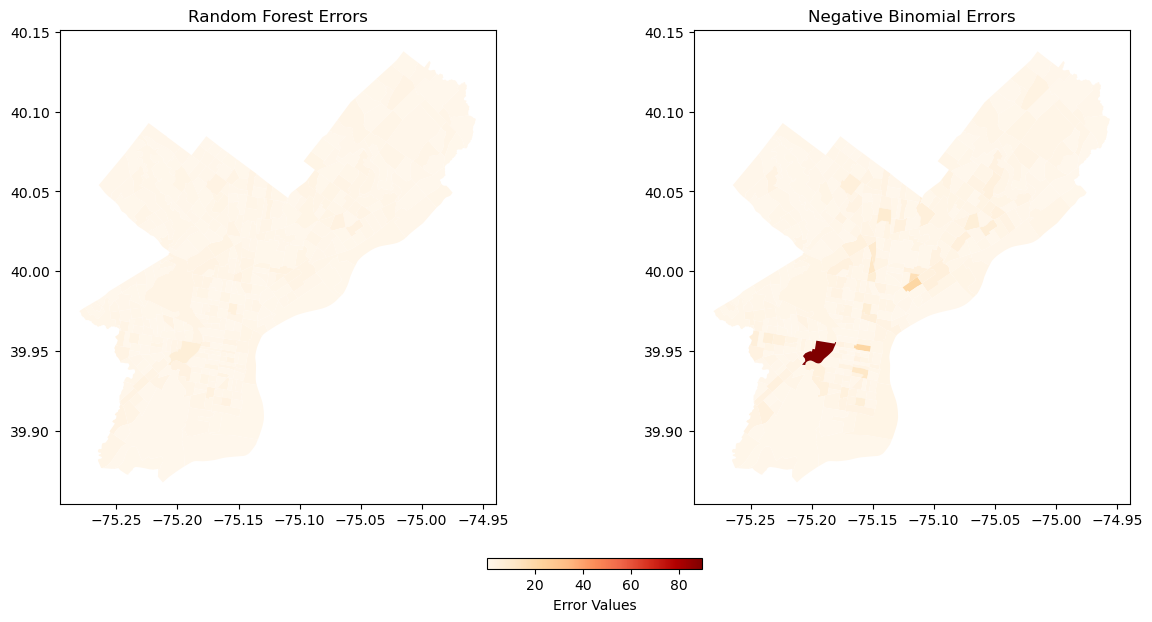

In [16]:
# add errors to geo_data
geo_data['rf_errors'] = errors
geo_data['nb_errors'] = nb_errors

# Define a common color map and normalization
vmin = min(geo_data['rf_errors'].min(), geo_data['nb_errors'].min())
vmax = max(geo_data['rf_errors'].max(), geo_data['nb_errors'].max())
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = 'OrRd'  # Using 'OrRd' as the common color map

# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Plot the map for random forest errors
geo_data.plot(column='rf_errors', cmap=cmap, norm=norm, ax=ax1, legend=False)
ax1.set_title('Random Forest Errors')

# Plot the map for negative binomial errors
geo_data.plot(column='nb_errors', cmap=cmap, norm=norm, ax=ax2, legend=False)
ax2.set_title('Negative Binomial Errors')

# Add a shared color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=[ax1, ax2], orientation='horizontal', fraction=0.02, pad=0.1)
cbar.set_label('Error Values')

plt.show()

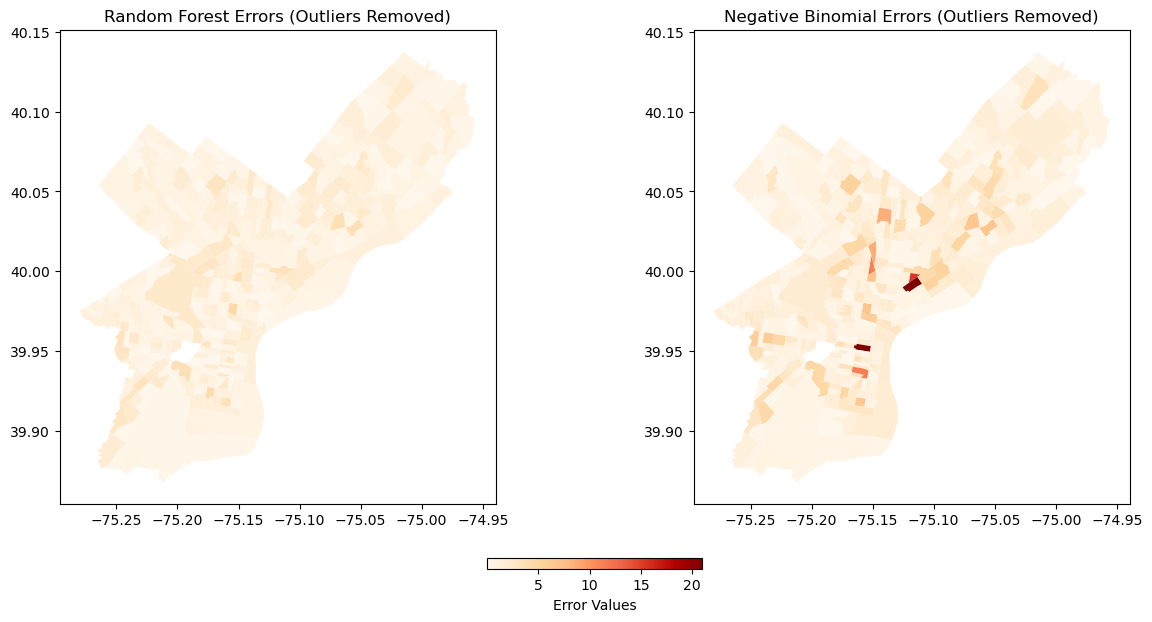

In [17]:
# Remove outliers in nb_errors greater than 75
filtered_geo_data = geo_data[geo_data['nb_errors'] <= 75]

# Define a common color map and normalization
vmin = min(filtered_geo_data['rf_errors'].min(), filtered_geo_data['nb_errors'].min())
vmax = max(filtered_geo_data['rf_errors'].max(), filtered_geo_data['nb_errors'].max())
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = 'OrRd'  # Using 'OrRd' as the common color map

# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Plot the map for random forest errors
filtered_geo_data.plot(column='rf_errors', cmap=cmap, norm=norm, ax=ax1, legend=False)
ax1.set_title('Random Forest Errors (Outlier Removed)')

# Plot the map for negative binomial errors
filtered_geo_data.plot(column='nb_errors', cmap=cmap, norm=norm, ax=ax2, legend=False)
ax2.set_title('Negative Binomial Errors (Outlier Removed)')

# Add a shared color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=[ax1, ax2], orientation='horizontal', fraction=0.02, pad=0.1)
cbar.set_label('Error Values')

plt.show()